In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 赛道标签清洗函数
def clean_label(label):
    # 1. 先去掉前置题号
    label = re.sub(r'^\d+、', '', label)
    # 2. 如果有“—”或“-”，优先取其后的内容
    if '—' in label:
        label = label.split('—', 1)[1]
    elif '-' in label:
        label = label.split('-', 1)[1]
    # 3. 特殊情况：如果还剩下“兴趣程度如何”这类题干，尝试提取后面的“编号.名称”
    if "兴趣程度" in label or "度如何" in label or "每个赛道" in label:
        m = re.search(r'[\d]+[\.、．]\s*([^\n，。？]*)', label)
        if m:
            label = m.group(1)
    # 4. 再统一去掉开头编号（如"2."、"10."、"15."、“2、”等，中英文点号、顿号、冒号、全角冒号、空格）
    label = re.sub(r'^[\d]+[\.、．:：、\s]*', '', label)
    # 5. 去除括号及内容
    label = re.sub(r'（.*?）', '', label)
    label = re.sub(r'\(.*?\)', '', label)
    # 6. 去除剩余左右空格
    return label.strip()
    
# 数据读取与整理
data = pd.read_excel(r"D:\大一\课程\概率论\大作业\大作业数据.xlsx")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
data.columns = [re.sub(r'\s+', '', col) for col in data.columns]

def extract_numeric(df, cols):
    return df[cols].apply(lambda s: pd.to_numeric(s.astype(str).str.extract(r'(\d+)')[0], errors='coerce'))

interest_cols = [c for c in data.columns if c.startswith('11、')]
difficulty_cols = [c for c in data.columns if c.startswith('12、')]
socval_cols = [c for c in data.columns if c.startswith('14、')]
willing_cols = [c for c in data.columns if c.startswith('17、')]
sex_col = '1、你的性别是'
coding_col = '4、你觉得与科创实验班其他同学相比，你目前（大一下学期）的编程能力'
sports_col = '8、你平均每周花多少时间在运动锻炼上？'
games_col = '9、你平均每周花多少时间在电子游戏上（含手机游戏、电脑游戏、主机游戏等）'
grade_col = '2、你在进入科创实验班之前的专业'

interest_scores = extract_numeric(data, interest_cols)
difficulty_scores = extract_numeric(data, difficulty_cols)
socval_scores = extract_numeric(data, socval_cols)
willing_scores = extract_numeric(data, willing_cols)


1. 人形机器人赛道的平均兴趣
人形机器人赛道的平均兴趣评分：3.7948717948717947


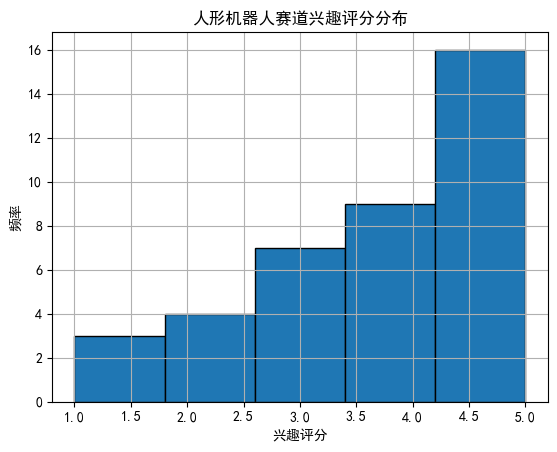

In [20]:
# 1. 人形机器人赛道的平均兴趣
print("\n1. 人形机器人赛道的平均兴趣")
import matplotlib.pyplot as plt

# 列名
col = '11、从消费者（而非创业者）的角度，你对以下每个赛道的兴趣程度如何（该领域会出现你希望了解甚至购买的产品吗）？—1.人形机器人'

# 1. 计算平均兴趣评分
humanoid_robot_mean = data[col].mean()
print(f"人形机器人赛道的平均兴趣评分：{humanoid_robot_mean}")

# 2. 可视化分布
data[col].hist(bins=5, edgecolor='black')
plt.title('人形机器人赛道兴趣评分分布')
plt.xlabel('兴趣评分')
plt.ylabel('频率')
plt.show()



2. 不同创业赛道的平均技术难度
人形机器人 的平均难度评分：4.69
竞技运动 的平均难度评分：3.10
户外休闲 的平均难度评分：2.59
健康科技 的平均难度评分：2.77
智能家居 的平均难度评分：2.59
宠物经济 的平均难度评分：2.44
养老 的平均难度评分：2.90
助残 的平均难度评分：3.90
教育培训 的平均难度评分：2.87
兴趣爱好 的平均难度评分：2.92
医疗检测 的平均难度评分：3.56
医疗干预 的平均难度评分：3.85
元宇宙 的平均难度评分：4.51
消费电子 的平均难度评分：3.21
移动机器人相关 的平均难度评分：3.79
工业机器人相关 的平均难度评分：3.82


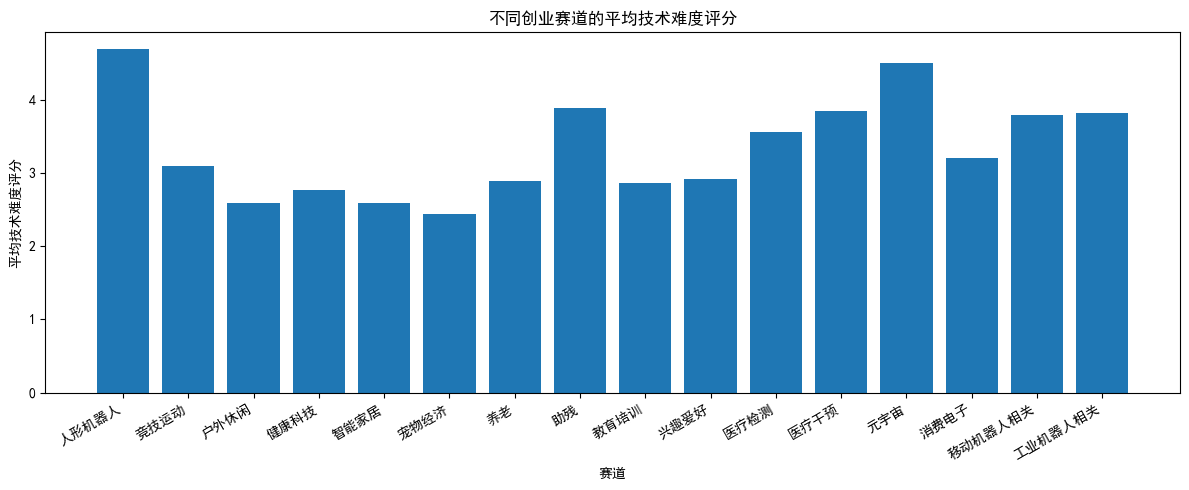

In [21]:
# 2. 不同创业赛道的平均技术难度
print("\n2. 不同创业赛道的平均技术难度")
# 找出所有“难度”相关的列名（包含“12、”）
difficulty_cols = [col for col in data.columns if "12、" in col]

# 计算每个赛道的平均难度
difficulty_means = {col: data[col].mean() for col in difficulty_cols}

# 打印结果（只显示主名）
for k, v in difficulty_means.items():
    print(f"{clean_label(k)} 的平均难度评分：{v:.2f}")

# 可视化（x轴主名，无序号、无括号、无描述）
plt.figure(figsize=(12, 5))
plt.bar(range(len(difficulty_means)),
        list(difficulty_means.values()),
        tick_label=[clean_label(col) for col in difficulty_means.keys()])
plt.ylabel('平均技术难度评分')
plt.xlabel('赛道')
plt.title('不同创业赛道的平均技术难度评分')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



3. 编程能力与创业赛道选择的相关性
编程能力与各赛道兴趣相关系数：
人形机器人: 0.08
竞技运动: 0.02
户外休闲: 0.19
健康科技: -0.10
智能家居: -0.14
宠物经济: 0.17
养老: 0.12
助残: 0.32
教育培训: -0.11
兴趣爱好: -0.16
医疗检测: 0.25
医疗干预: 0.23
元宇宙: 0.26
消费电子: 0.32
移动机器人相关: 0.21
工业机器人相关: 0.17


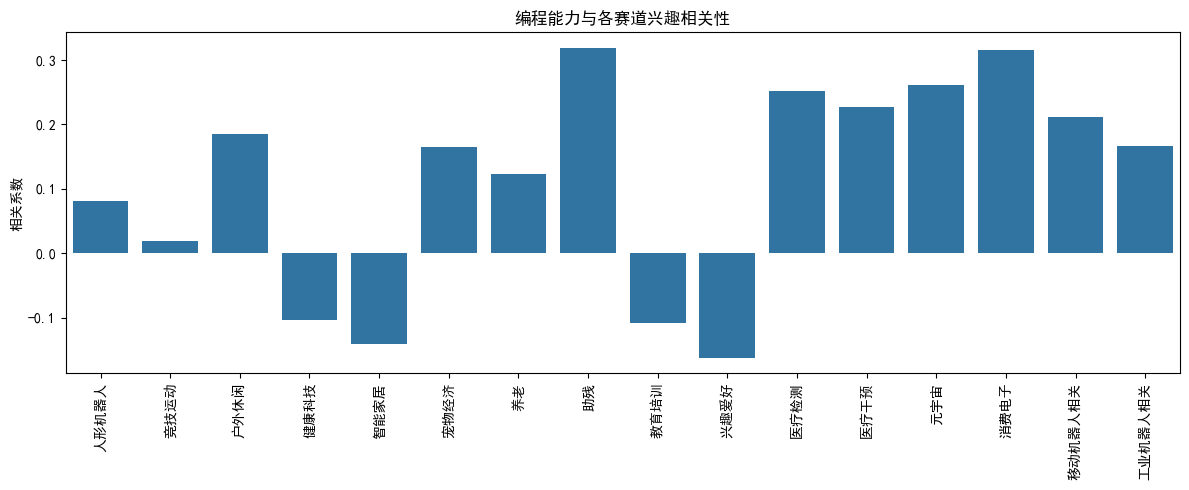

In [15]:
# 3. 编程能力与创业赛道选择的相关性（矩估计法）
print("\n13. 编程能力与创业赛道选择的相关性")
coding_bin = (data[coding_col] == 'C.偏强').astype(int)
corrs = []
for col in interest_cols:
    vals = interest_scores[col]
    mask = ~vals.isna()
    if mask.sum() > 0:
        corr = np.corrcoef(coding_bin[mask], vals[mask])[0,1]
    else:
        corr = np.nan
    corrs.append(corr)
print("编程能力与各赛道兴趣相关系数：")
for c, v in zip(interest_cols, corrs):
    print(f"{clean_label(c)}: {v:.2f}")
plt.figure(figsize=(12,5))
sns.barplot(x=[clean_label(c) for c in interest_cols], y=corrs)
plt.xticks(rotation=90)
plt.ylabel('相关系数')
plt.title('编程能力与各赛道兴趣相关性')
plt.tight_layout(); plt.show()


4. 编程基础偏强同学的兴趣偏好
偏强同学人数： 8
高技术难度兴趣赛道： ['助残', '医疗干预', '元宇宙', '移动机器人相关', '工业机器人相关']
偏强同学在高难度赛道兴趣均值：
助残: 3.62
医疗干预: 3.88
元宇宙: 4.50
移动机器人相关: 4.38
工业机器人相关: 3.88
助残 偏强同学兴趣MLE: 均值=3.62, 标准差=0.70
医疗干预 偏强同学兴趣MLE: 均值=3.88, 标准差=0.78
元宇宙 偏强同学兴趣MLE: 均值=4.50, 标准差=0.71
移动机器人相关 偏强同学兴趣MLE: 均值=4.38, 标准差=0.99
工业机器人相关 偏强同学兴趣MLE: 均值=3.88, 标准差=1.05


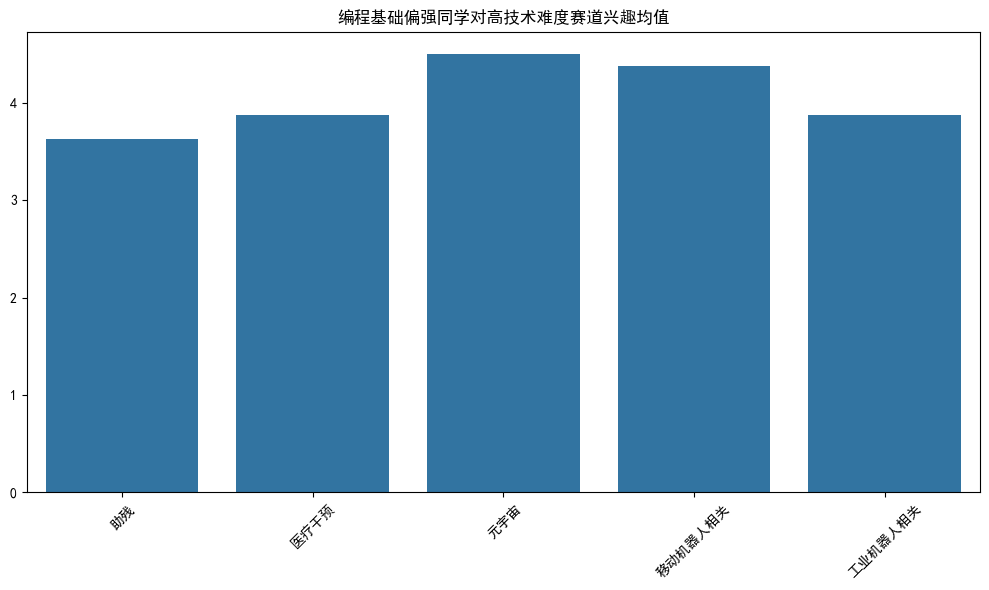

In [4]:
# 4. 编程基础偏强同学的兴趣偏好
print("\n4. 编程基础偏强同学的兴趣偏好")
strong_mask = data[coding_col] == 'C.偏强'
print("偏强同学人数：", strong_mask.sum())
mean_difficulties = difficulty_scores.mean()
threshold = mean_difficulties.quantile(2/3)
hard_tracks_difficulty = mean_difficulties[mean_difficulties >= threshold].index
hard_tracks_interest = [col.replace('12、', '11、') for col in hard_tracks_difficulty if col.replace('12、', '11、') in interest_scores.columns]
print("高技术难度兴趣赛道：", [clean_label(c) for c in hard_tracks_interest])
hard_interest_strong = interest_scores.loc[strong_mask, hard_tracks_interest].mean()
print("偏强同学在高难度赛道兴趣均值：")
for col, val in hard_interest_strong.items():
    print(f"{clean_label(col)}: {val:.2f}")
for col in hard_tracks_interest:
    vals = interest_scores.loc[strong_mask, col].dropna()
    if len(vals) == 0:
        print(f"{clean_label(col)} 偏强同学无有效兴趣数据，跳过")
        continue
    mu, std = stats.norm.fit(vals)
    print(f"{clean_label(col)} 偏强同学兴趣MLE: 均值={mu:.2f}, 标准差={std:.2f}")
plt.figure(figsize=(10,6))
plot_data = hard_interest_strong.dropna()
if not plot_data.empty:
    sns.barplot(x=[clean_label(c) for c in plot_data.index], y=plot_data.values)
    plt.title('编程基础偏强同学对高技术难度赛道兴趣均值')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("无足够有效数据用于绘图！")


5. 性别差异对创业赛道兴趣的影响
人形机器人: 男均值=3.91, 女均值=3.29 | t=1.15, p=0.2585
竞技运动: 男均值=3.16, 女均值=2.71 | t=0.81, p=0.4245
户外休闲: 男均值=3.69, 女均值=3.14 | t=1.15, p=0.2578
健康科技: 男均值=3.91, 女均值=3.43 | t=1.19, p=0.2429
智能家居: 男均值=3.69, 女均值=4.29 | t=-1.34, p=0.1882
宠物经济: 男均值=3.19, 女均值=3.43 | t=-0.47, p=0.6431
养老: 男均值=3.22, 女均值=3.86 | t=-1.26, p=0.2146
助残: 男均值=2.81, 女均值=3.43 | t=-1.32, p=0.1963
教育培训: 男均值=2.59, 女均值=3.43 | t=-1.77, p=0.0855
兴趣爱好: 男均值=3.34, 女均值=3.14 | t=0.49, p=0.6287
医疗检测: 男均值=3.22, 女均值=3.57 | t=-0.69, p=0.4932
医疗干预: 男均值=3.31, 女均值=3.71 | t=-0.86, p=0.3949
元宇宙: 男均值=3.78, 女均值=4.14 | t=-0.67, p=0.5085
消费电子: 男均值=3.84, 女均值=3.86 | t=-0.03, p=0.9764
移动机器人相关: 男均值=3.88, 女均值=4.00 | t=-0.25, p=0.8010
工业机器人相关: 男均值=3.44, 女均值=3.57 | t=-0.25, p=0.8049


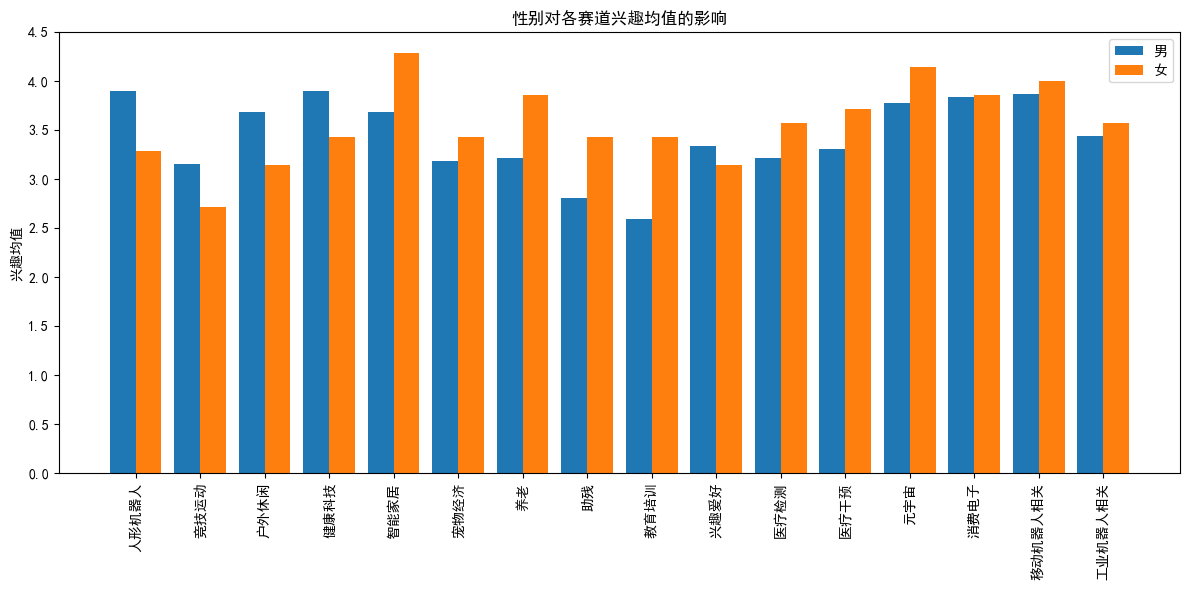

In [13]:
# 5. 性别差异对创业赛道兴趣的影响

print("\n5. 性别差异对创业赛道兴趣的影响")
male_mask = data[sex_col] == 'A.男'
female_mask = data[sex_col] == 'B.女'
male_interest = interest_scores[male_mask].mean()
female_interest = interest_scores[female_mask].mean()
for col in interest_cols:
    m_vals = interest_scores.loc[male_mask, col].dropna()
    f_vals = interest_scores.loc[female_mask, col].dropna()
    if len(m_vals)==0 or len(f_vals)==0:
        print(f"{clean_label(col)}: 男或女无数据，跳过")
        continue
    mu_m, std_m = stats.norm.fit(m_vals)
    mu_f, std_f = stats.norm.fit(f_vals)
    t, p = stats.ttest_ind(m_vals, f_vals, nan_policy='omit')
    print(f"{clean_label(col)}: 男均值={mu_m:.2f}, 女均值={mu_f:.2f} | t={t:.2f}, p={p:.4f}")
index = range(len(interest_cols))
plt.figure(figsize=(12,6))
plt.bar(index, male_interest, width=0.4, label='男')
plt.bar([i+0.4 for i in index], female_interest, width=0.4, label='女')
plt.xticks([i+0.2 for i in index], [clean_label(c) for c in interest_cols], rotation=90)
plt.ylabel('兴趣均值')
plt.title('性别对各赛道兴趣均值的影响')
plt.legend()
plt.tight_layout(); plt.show()


6. 技术难度对创业意愿的影响
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.603
Date:                Mon, 09 Jun 2025   Prob (F-statistic):             0.0104
Time:                        10:42:07   Log-Likelihood:                -976.51
No. Observations:                 624   AIC:                             1957.
Df Residuals:                     622   BIC:                             1966.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7733      0.153   

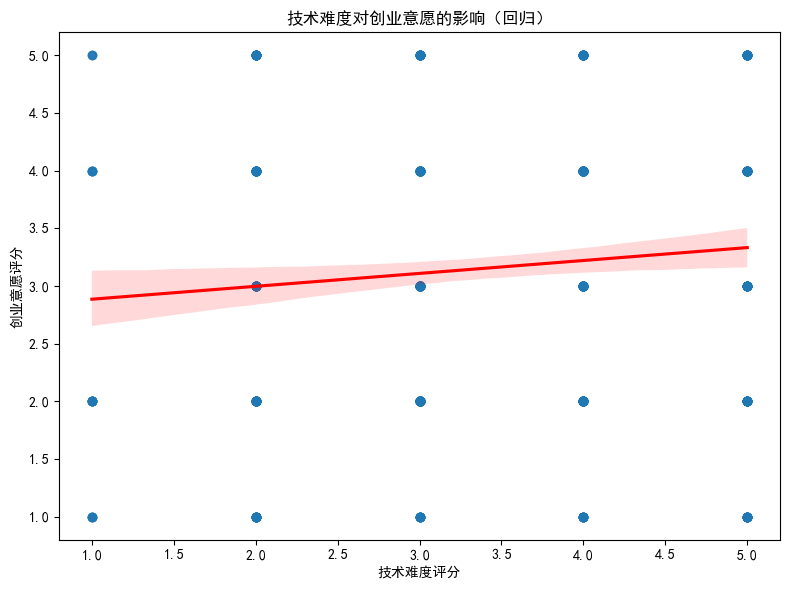

In [14]:
# 6. 技术难度对创业意愿的影响
print("\n6. 技术难度对创业意愿的影响")
diff_flat = difficulty_scores.values.flatten()
willing_flat = willing_scores.values.flatten()
mask = (~np.isnan(diff_flat)) & (~np.isnan(willing_flat))
X = sm.add_constant(diff_flat[mask])
model = sm.OLS(willing_flat[mask], X).fit()
print(model.summary())
plt.figure(figsize=(8,6))
sns.regplot(x=diff_flat[mask], y=willing_flat[mask], line_kws={'color':'red'})
plt.xlabel('技术难度评分')
plt.ylabel('创业意愿评分')
plt.title('技术难度对创业意愿的影响（回归）')
plt.tight_layout(); plt.show()


7. 社会价值高与商业赛道兴趣差异
社会价值高均值=3.35, 商业赛道均值=3.65 | t=-1.86, p=0.0663


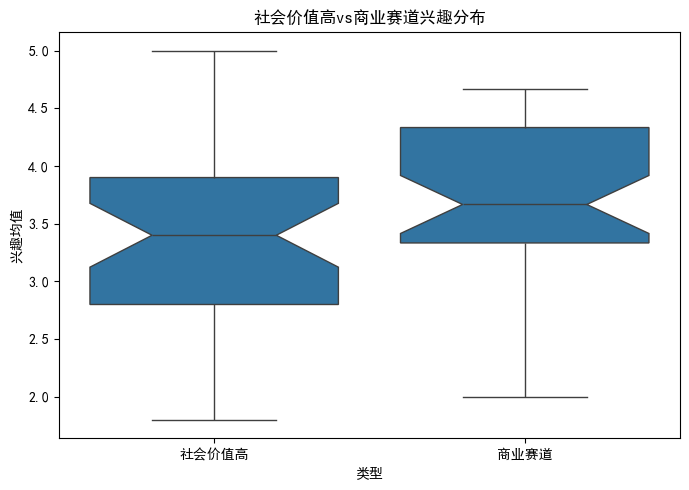

In [7]:
# 7. 社会价值高与商业赛道兴趣差异
print("\n7. 社会价值高与商业赛道兴趣差异")
socval_high_cols = [c for c in socval_cols if any(k in c for k in ['健康科技', '助残', '养老', '医疗检测', '医疗干预'])]
business_cols = [c for c in socval_cols if any(k in c for k in ['消费电子', '兴趣爱好', '智能家居'])]
socval_high_interest_cols = [c.replace('14、','11、') for c in socval_high_cols if c.replace('14、','11、') in interest_scores.columns]
business_interest_cols = [c.replace('14、','11、') for c in business_cols if c.replace('14、','11、') in interest_scores.columns]
socval_high_interest = interest_scores[socval_high_interest_cols].mean(axis=1)
business_interest = interest_scores[business_interest_cols].mean(axis=1)
mu1, std1 = stats.norm.fit(socval_high_interest.dropna())
mu2, std2 = stats.norm.fit(business_interest.dropna())
t, p = stats.ttest_ind(socval_high_interest.dropna(), business_interest.dropna())
print(f"社会价值高均值={mu1:.2f}, 商业赛道均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")

# 使用长格式DataFrame画boxplot，避免seaborn报错
df_box = pd.DataFrame({
    '类型': ['社会价值高'] * len(socval_high_interest.dropna()) + ['商业赛道'] * len(business_interest.dropna()),
    '兴趣均值': pd.concat([socval_high_interest.dropna(), business_interest.dropna()], ignore_index=True)
})
plt.figure(figsize=(7,5))
sns.boxplot(x='类型', y='兴趣均值', data=df_box, notch=True)
plt.ylabel('兴趣均值')
plt.title('社会价值高vs商业赛道兴趣分布')
plt.tight_layout()
plt.show()


8. 运动偏好对竞技赛道的兴趣
偏好运动人数：26, 非偏好人数：13
运动偏好均值=3.31, 非偏好均值=2.62 | t=1.59, p=0.1198


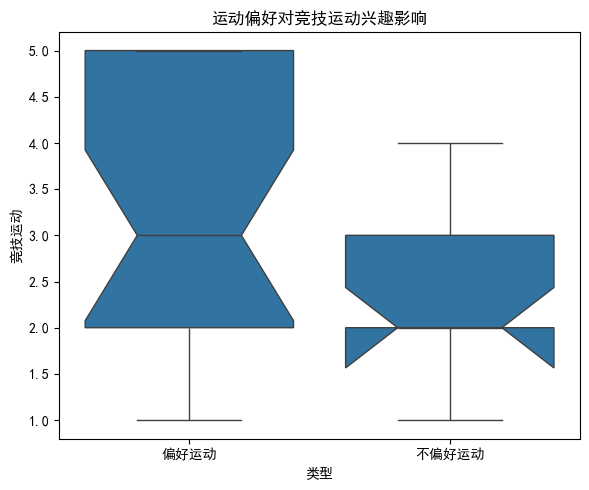

In [8]:
# 8. 运动偏好对竞技赛道的兴趣
print("\n8. 运动偏好对竞技赛道的兴趣")
sport_map = {
    'A.0-1': 0.5,
    'B.1-2': 1.5,
    'C.2-4': 3.0,
    'D.4-8': 6.0,
    'E.8以上': 10.0
}
sport_time = data[sports_col].map(sport_map)
strong_sport = sport_time > 2
sports_interest_col = [c for c in interest_cols if '竞技运动' in c]
if sports_interest_col:
    sports_interest = interest_scores[sports_interest_col[0]]
    group1 = sports_interest[strong_sport].dropna()
    group2 = sports_interest[~strong_sport].dropna()
    print(f"偏好运动人数：{len(group1)}, 非偏好人数：{len(group2)}")
    if len(group1) == 0 or len(group2) == 0:
        print("某组数据为空，无法进行统计和绘图。")
    else:
        mu1, std1 = stats.norm.fit(group1)
        mu2, std2 = stats.norm.fit(group2)
        t, p = stats.ttest_ind(group1, group2)
        print(f"运动偏好均值={mu1:.2f}, 非偏好均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")
        # 绘图
        df_box = pd.DataFrame({
            '类型': ['偏好运动'] * len(group1) + ['不偏好运动'] * len(group2),
            '竞技运动兴趣': pd.concat([group1, group2], ignore_index=True)
        })
        plt.figure(figsize=(6,5))
        sns.boxplot(x='类型', y='竞技运动兴趣', data=df_box, notch=True)
        plt.ylabel(clean_label(sports_interest_col[0]))
        plt.title('运动偏好对竞技运动兴趣影响')
        plt.tight_layout()
        plt.show()
else:
    print("未找到竞技运动兴趣列！")


9. 游戏偏好对竞技赛道的兴趣
偏好游戏人数：36, 非偏好人数：3
游戏偏好均值=3.17, 非偏好均值=2.00 | t=1.51, p=0.1390


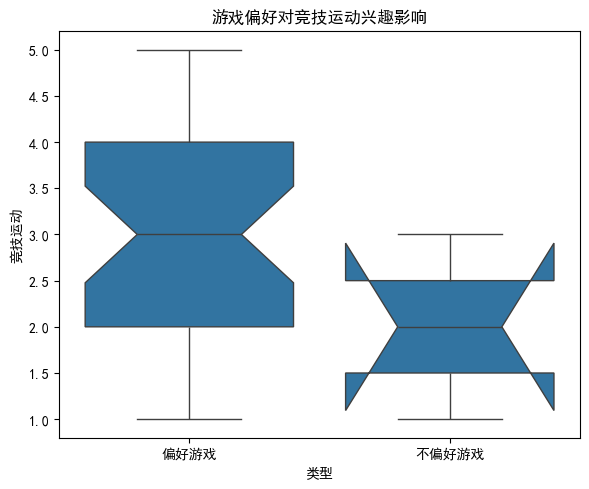

In [9]:
# 9. 游戏偏好对竞技赛道的兴趣
print("\n9. 游戏偏好对竞技赛道的兴趣")
game_map = {
    'A.小于1': 0.5,
    'B.1-4': 2.5,
    'C.3-5': 4.0,
    'D.5-7': 6.0,
    'E.7以上': 8.0
}
game_time = data[games_col].map(game_map)
strong_game = game_time > 2  # 或你想设定的阈值
sports_interest_col = [c for c in interest_cols if '竞技运动' in c]
if sports_interest_col:
    sports_interest = interest_scores[sports_interest_col[0]]
    group1 = sports_interest[strong_game].dropna()
    group2 = sports_interest[~strong_game].dropna()
    print(f"偏好游戏人数：{len(group1)}, 非偏好人数：{len(group2)}")
    if len(group1) == 0 or len(group2) == 0:
        print("某组数据为空，无法进行统计和绘图。")
    else:
        mu1, std1 = stats.norm.fit(group1)
        mu2, std2 = stats.norm.fit(group2)
        t, p = stats.ttest_ind(group1, group2)
        print(f"游戏偏好均值={mu1:.2f}, 非偏好均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")
        # 绘图
        df_box = pd.DataFrame({
            '类型': ['偏好游戏'] * len(group1) + ['不偏好游戏'] * len(group2),
            '竞技运动兴趣': pd.concat([group1, group2], ignore_index=True)
        })
        plt.figure(figsize=(6,5))
        sns.boxplot(x='类型', y='竞技运动兴趣', data=df_box, notch=True)
        plt.ylabel(clean_label(sports_interest_col[0]))
        plt.title('游戏偏好对竞技运动兴趣影响')
        plt.tight_layout()
        plt.show()
else:
    print("未找到竞技运动兴趣列！")


10. 问卷数据中的常见模式
各赛道兴趣均值（最大似然估计）:
移动机器人相关: 均值=3.90
元宇宙: 均值=3.85
消费电子: 均值=3.85
健康科技: 均值=3.82
人形机器人: 均值=3.79
智能家居: 均值=3.79
户外休闲: 均值=3.59
工业机器人相关: 均值=3.46
医疗干预: 均值=3.38
养老: 均值=3.33
兴趣爱好: 均值=3.31
医疗检测: 均值=3.28
宠物经济: 均值=3.23
竞技运动: 均值=3.08
助残: 均值=2.92
教育培训: 均值=2.74

结论：
问卷数据显示，对“移动机器人相关”赛道存在普遍偏好（平均兴趣分最高，为3.90）。


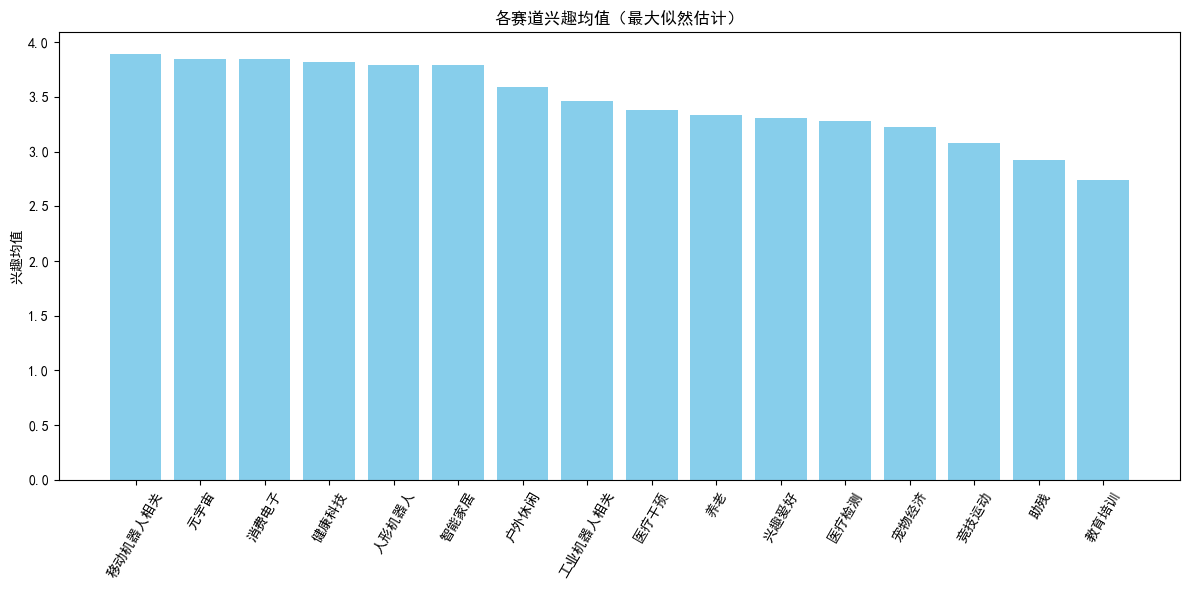

In [23]:
# 10. 问卷数据中的常见模式
print("\n10. 问卷数据中的常见模式")

# 1. 最大似然估计各赛道的兴趣均值
mean_results = {}
for col in interest_cols:
    vals = interest_scores[col].dropna()
    if len(vals) == 0:
        continue
    mu, std = stats.norm.fit(vals)
    mean_results[col] = mu

# 2. 按均值排序，输出
sorted_means = sorted(mean_results.items(), key=lambda x: x[1], reverse=True)
print("各赛道兴趣均值（最大似然估计）:")
for col, mu in sorted_means:
    print(f"{clean_label(col)}: 均值={mu:.2f}")

# 3. 找出偏好最高的赛道
top_label, top_mean = clean_label(sorted_means[0][0]), sorted_means[0][1]
print("\n结论：")
print(f"问卷数据显示，对“{top_label}”赛道存在普遍偏好（平均兴趣分最高，为{top_mean:.2f}）。")

# 4. 可视化：所有赛道兴趣均值（条形图）
labels = [clean_label(x[0]) for x in sorted_means]
means = [x[1] for x in sorted_means]

plt.figure(figsize=(12,6))
plt.bar(labels, means, color='skyblue')
plt.ylabel('兴趣均值')
plt.title('各赛道兴趣均值（最大似然估计）')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


11. 创业热情与赛道选择的关系
人形机器人 高热情均值=4.05, 低热情均值=3.55 | t=1.21, p=0.2328
竞技运动 高热情均值=3.42, 低热情均值=2.75 | t=1.64, p=0.1095
户外休闲 高热情均值=3.89, 低热情均值=3.30 | t=1.67, p=0.1043
健康科技 高热情均值=3.95, 低热情均值=3.70 | t=0.79, p=0.4333
智能家居 高热情均值=3.95, 低热情均值=3.65 | t=0.86, p=0.3975
宠物经济 高热情均值=3.68, 低热情均值=2.80 | t=2.39, p=0.0220
养老 高热情均值=3.63, 低热情均值=3.05 | t=1.51, p=0.1391
助残 高热情均值=3.42, 低热情均值=2.45 | t=2.93, p=0.0058
教育培训 高热情均值=3.32, 低热情均值=2.20 | t=3.38, p=0.0017
兴趣爱好 高热情均值=3.58, 低热情均值=3.05 | t=1.73, p=0.0914
医疗检测 高热情均值=3.53, 低热情均值=3.05 | t=1.23, p=0.2249
医疗干预 高热情均值=3.58, 低热情均值=3.20 | t=1.06, p=0.2948
元宇宙 高热情均值=4.21, 低热情均值=3.50 | t=1.77, p=0.0851
消费电子 高热情均值=4.11, 低热情均值=3.60 | t=1.51, p=0.1406
移动机器人相关 高热情均值=4.00, 低热情均值=3.80 | t=0.53, p=0.5988
工业机器人相关 高热情均值=3.68, 低热情均值=3.25 | t=1.07, p=0.2935


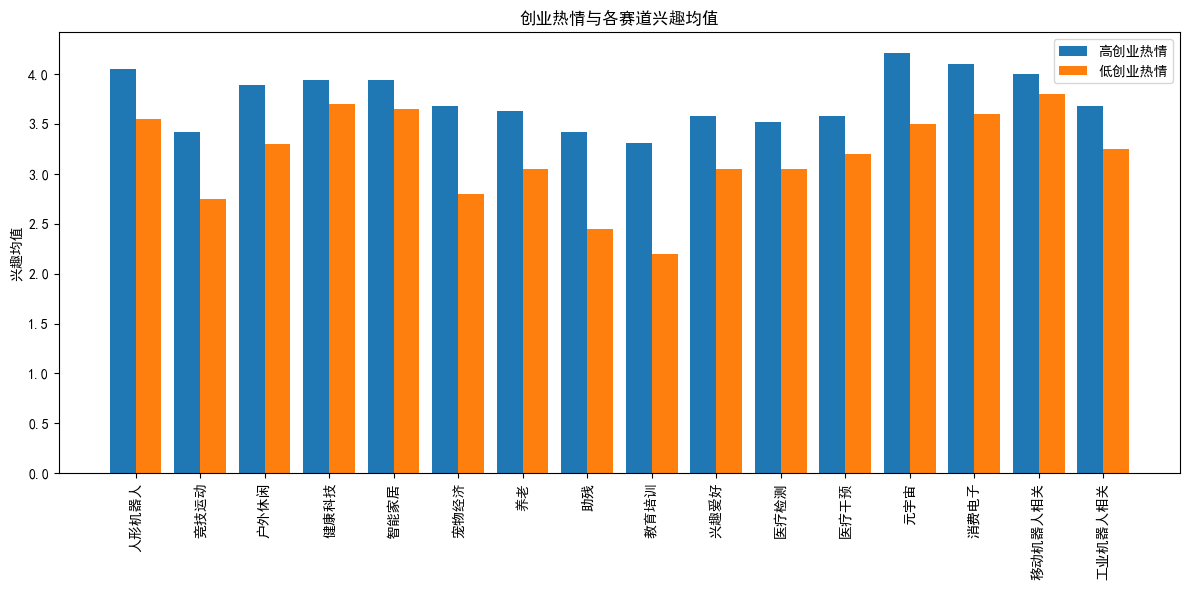

In [10]:
# 11. 创业热情与赛道选择的关系
print("\n11. 创业热情与赛道选择的关系")
mean_willing = willing_scores.mean(axis=1)
high_enthusiasm = mean_willing > mean_willing.median()
for col in interest_cols:
    hi = interest_scores.loc[high_enthusiasm, col].dropna()
    lo = interest_scores.loc[~high_enthusiasm, col].dropna()
    if len(hi)==0 or len(lo)==0:
        print(f"{clean_label(col)}: 高或低热情无数据，跳过")
        continue
    mu1, std1 = stats.norm.fit(hi)
    mu2, std2 = stats.norm.fit(lo)
    t,p = stats.ttest_ind(hi, lo)
    print(f"{clean_label(col)} 高热情均值={mu1:.2f}, 低热情均值={mu2:.2f} | t={t:.2f}, p={p:.4f}")
plt.figure(figsize=(12,6))
high_vals = interest_scores[high_enthusiasm].mean()
low_vals = interest_scores[~high_enthusiasm].mean()
plt.bar(index, high_vals, width=0.4, label='高创业热情')
plt.bar([i+0.4 for i in index], low_vals, width=0.4, label='低创业热情')
plt.xticks([i+0.2 for i in index], [clean_label(c) for c in interest_cols], rotation=90)
plt.ylabel('兴趣均值')
plt.title('创业热情与各赛道兴趣均值')
plt.legend()
plt.tight_layout(); plt.show()



12. 技术难度评分最大似然估计&正态分布检验
所有赛道技术难度分布均值(MLE)=3.34, std=1.07| 正态性p=0.0000 (p>0.05则基本服从正态)


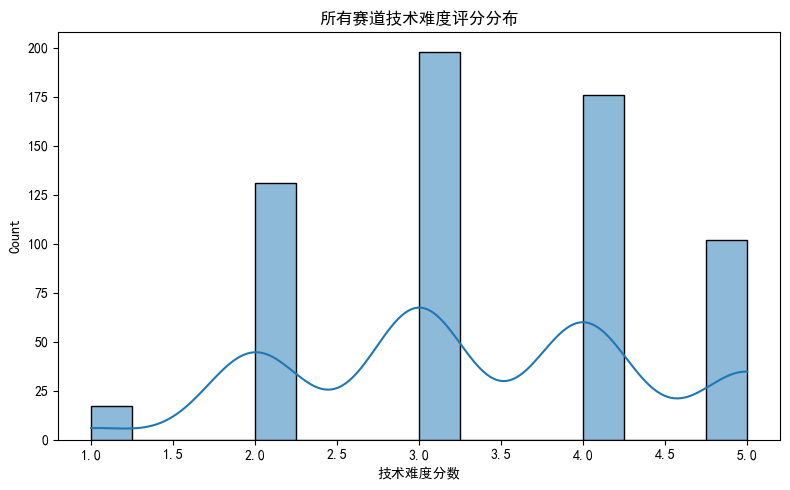

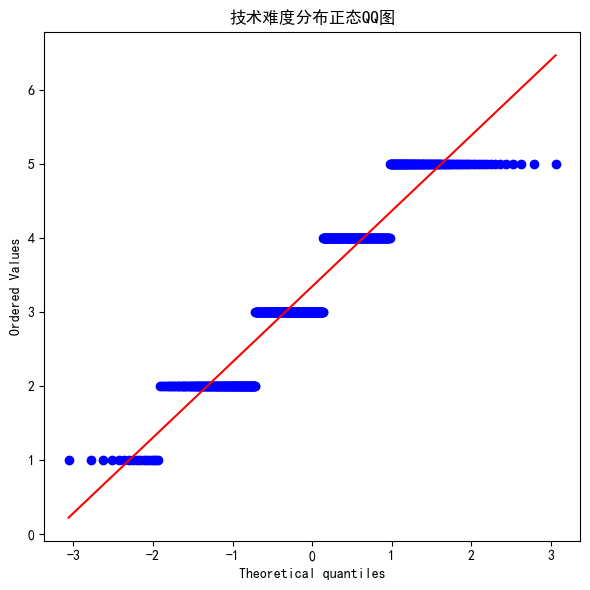

In [11]:
# 12. 技术难度评分最大似然估计&正态分布检验
print("\n12. 技术难度评分最大似然估计&正态分布检验")
all_difficulty = difficulty_scores.values.flatten()
all_difficulty = all_difficulty[~np.isnan(all_difficulty)]
mu, std = stats.norm.fit(all_difficulty)
k2, p = stats.normaltest(all_difficulty)
print(f"所有赛道技术难度分布均值(MLE)={mu:.2f}, std={std:.2f}| 正态性p={p:.4f} (p>0.05则基本服从正态)")
plt.figure(figsize=(8,5))
sns.histplot(all_difficulty, bins=16, kde=True)
plt.title('所有赛道技术难度评分分布')
plt.xlabel('技术难度分数')
plt.tight_layout(); plt.show()
plt.figure(figsize=(6,6))
stats.probplot(all_difficulty, dist="norm", plot=plt)
plt.title('技术难度分布正态QQ图')
plt.tight_layout(); plt.show()